# Bootstrap Lasso Experiments
The goal of this notebook is to experiment with different details of a bootstrap lasso implementation, including handling input and output data, formula, parallelization, and plotting

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid")

## Basics

In [2]:
# Make some fake data
X, y = make_regression(n_samples = 2000, n_features = 20, n_informative = 10, noise = 4, random_state = 0)

In [3]:
# Fit single Lasso regression with CV Lambda
reg = LassoCV(cv = 5, random_state = 0).fit(X, y)

In [4]:
# Optimal lambda (called alpha here)
opt_alpha = reg.alpha_
print(f"Optimal alpha is {opt_alpha}")

Optimal alpha is 0.0953083247935252


In [5]:
# Coefficients when fit with optimal alpha
reg.coef_

array([ 9.65335951e+01,  3.69831060e+01,  7.25719525e+01, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.28292562e-02,  3.54511613e-03,
        5.58463728e+01,  8.72839409e+01, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  3.32446275e-02,  9.60642969e+01,  4.46156811e+01,
        8.00426110e+00,  8.16777795e+01,  3.40097205e+01, -8.35550365e-02])

### Experiment 1
+ sklearn  
+ non-parallel  
+ numpy matrix inputs and outputs  

In [6]:
# Simple bootstrap
N =  500 # Number of bootstrap iterations
n_rows = X.shape[0]
n_cols = X.shape[1]
# Empty matrix to store coefficients; each row will be a bootstrap outcome, each column a variable
bs_results = np.empty(shape = (N, n_cols))
for i in range(N):
    # Randomly sample row indices with replacement
    # idx = np.random.choice(np.arange(n_rows), size = n_rows, replace = True)
    # Slightly faster:
    idx = np.random.randint(0, n_rows, n_rows)
    # Fit Lasso regression on sampled rows with CV Lambda
    reg = LassoCV(cv = 5, random_state = 0).fit(X[idx,], y[idx,])
    # Store coefficients
    bs_results[i] = reg.coef_

In [7]:
# Get fraction of bootstraps that include each variable
(abs(bs_results) > 0).mean(axis = 0)

array([1.   , 1.   , 1.   , 0.246, 0.268, 0.246, 0.668, 0.532, 1.   ,
       1.   , 0.496, 0.228, 0.346, 0.638, 1.   , 1.   , 1.   , 1.   ,
       1.   , 0.818])

### Experiment 2
+ sklearn  
+ non-parallel  
+ pandas dataframe inputs and outputs with formula

In [8]:
# Create data frame using previous X and y
df = pd.DataFrame(X, columns = ["var_" + str(i) for i in range(X.shape[1])])
df["y"] = y
df.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,y
0,-0.143692,-1.720325,2.174773,-0.166570,1.431844,0.935476,0.811172,-0.898043,-0.105477,-1.631266,...,0.762247,-1.170872,1.082268,-1.060018,0.560868,-1.000963,1.712960,-0.893363,-0.751994,-48.241475
1,0.760652,-0.946930,2.070693,1.022958,-1.542727,-0.913354,-1.540954,-1.083286,0.494218,-1.933970,...,-0.669237,0.707848,1.794478,1.253404,0.653315,0.577458,-0.782008,-0.647808,1.419360,114.386817
2,-1.016927,-0.030318,0.504924,-0.332379,0.423130,0.030544,-0.098371,0.968252,-0.911901,0.213048,...,0.971411,-0.248421,-1.079612,0.029954,-0.662192,-0.214717,-1.016476,-0.698976,1.594148,-233.072890
3,-0.011055,-0.224936,-0.799320,-1.627230,-1.687300,0.141413,-0.235578,-0.280442,-0.738897,-1.643724,...,0.812186,1.261733,-1.447640,-1.748073,0.646040,0.176605,-0.415429,2.224263,0.762691,-354.210675
4,-0.043859,0.453676,-0.471868,0.064971,0.543364,0.871053,-0.401273,0.278023,-0.936520,-1.591680,...,-1.800221,0.107869,-1.605771,-0.643826,0.073285,0.945265,-0.426766,-1.080712,0.124579,-336.819974


In [9]:
# Use patsy to create matrices from data frame and formula
import patsy
formula = "y ~ " + " + ".join(df.columns[:-1])
print(formula)

y ~ var_0 + var_1 + var_2 + var_3 + var_4 + var_5 + var_6 + var_7 + var_8 + var_9 + var_10 + var_11 + var_12 + var_13 + var_14 + var_15 + var_16 + var_17 + var_18 + var_19


In [10]:
# Create matrices
df_y, df_X = patsy.dmatrices(formula, data = df)

In [11]:
# Simple bootstrap
N =  500 # Number of bootstrap iterations
n_rows = df_X.shape[0]
n_cols = df_X.shape[1]
# Empty matrix to store coefficients; each row will be a bootstrap outcome, each column a variable
bs_results = np.empty(shape = (N, n_cols))
df_y = np.ravel(df_y) # LassoCV wants a 1d array
for i in range(N):
    # Randomly sample row indices with replacement
    #idx = np.random.choice(np.arange(n_rows), size = n_rows, replace = True)
    idx = np.random.randint(0, n_rows, n_rows)
    # Fit Lasso regression on sampled rows with CV Lambda
    reg = LassoCV(cv = 5, random_state = 0).fit(df_X[idx,], df_y[idx,])
    # Store coefficients
    bs_results[i] = reg.coef_

In [12]:
# Parse inclusion probabilities output into dataframe
vip_df = pd.DataFrame({"variable": df_X.design_info.column_names, 
                       "probability": (abs(bs_results) > 0).mean(axis = 0)})
vip_df

,variable,probability
0,Intercept,0.000
1,var_0,1.000
2,var_1,1.000
3,var_2,1.000
4,var_3,0.222
5,var_4,0.262
6,var_5,0.302
7,var_6,0.614
8,var_7,0.514
9,var_8,1.000


In [13]:
# Parse coefficients output into dataframe
coef_df = pd.DataFrame({"variable": df_X.design_info.column_names, 
                       "mean_coef": bs_results.mean(axis = 0),
                       "p_05": np.percentile(bs_results, q = 5, axis = 0),
                       "p_95": np.percentile(bs_results, q = 95, axis = 0)})
coef_df

,variable,mean_coef,p_05,p_95
0,Intercept,0.000000,0.000000,0.000000
1,var_0,96.524163,96.382520,96.658754
2,var_1,36.984200,36.836030,37.124248
3,var_2,72.573348,72.437057,72.711572
4,var_3,-0.002397,-0.046878,0.029678
5,var_4,-0.000091,-0.042683,0.042972
6,var_5,0.002297,-0.038769,0.057326
7,var_6,0.049833,0.000000,0.169683
8,var_7,0.034278,0.000000,0.134724
9,var_8,55.841125,55.709292,55.982399


### Experiment 3
+ Same as experiment 2, but wrapped in a function  
+ Plots

In [14]:
def bolasso(formula, data, n_boot):
    """Bootsrapped Lasso estimation for variable selection

    This function repeatedly samples rows of the data with replacement, applies the sklearn LassoCV function,
    and aggregates the results into two data frames. The first data frame contains the probability that a variable survives
    the lasso, calculated as the fraction of bootstrap iterations where the coefficient of the variable
    is not 0, and the second contains the mean and 90% interval for the coefficient estimates themselves,
    calculated over the bootstrap iterations.

    Parameters
    ----------
    formula : string
        Formula, e.g., "y ~ x". This formula will be parsed by patsy and used to create matrices to pass to LassoCV
    data : pandas.DataFrame
        Data frame containing the variables used the formula
    n_boot : int
        Number of bootstrap iterations

    Returns
    ----------
    tuple(pandas.DataFrame, pandas.DataFrame)
        Tuple containing data frames. The first data frame contains variable inclusion probabilities and the
        second contains coefficient estimates.
    """
    # Create matrices
    df_y, df_X = patsy.dmatrices(formula, data = data)
    # Simple bootstrap
    n_rows = df_X.shape[0]
    n_cols = df_X.shape[1]
    # Empty matrix to store coefficients; each row will be a bootstrap outcome, each column a variable
    bs_results = np.empty(shape = (n_boot, n_cols))
    df_y = np.ravel(df_y) # LassoCV wants a 1d array
    for i in range(n_boot):
        # Randomly sample row indices with replacement
        idx = np.random.randint(0, n_rows, n_rows)
        # Fit Lasso regression on sampled rows with CV Lambda
        reg = LassoCV(cv = 5, random_state = 0).fit(df_X[idx,], df_y[idx,])
        # Store coefficients
        bs_results[i] = reg.coef_
    # Parse inclusion probabilities output into dataframe
    vip_df = pd.DataFrame({"variable": df_X.design_info.column_names, 
                       "probability": (abs(bs_results) > 0).mean(axis = 0)})
    # Parse coefficients output into dataframe
    coef_df = pd.DataFrame({"variable": df_X.design_info.column_names, 
                       "mean_coef": bs_results.mean(axis = 0),
                       "p_05": np.percentile(bs_results, q = 5, axis = 0),
                       "p_95": np.percentile(bs_results, q = 95, axis = 0)})
    return vip_df, coef_df

In [15]:
# Test the function
my_formula = "y ~ " + " + ".join(df.columns[:-1]) # patsy doesn't have ability to do y ~ .
my_vip_df, my_coef_df = bolasso(formula = my_formula,
                                data = df,
                                n_boot = 500)

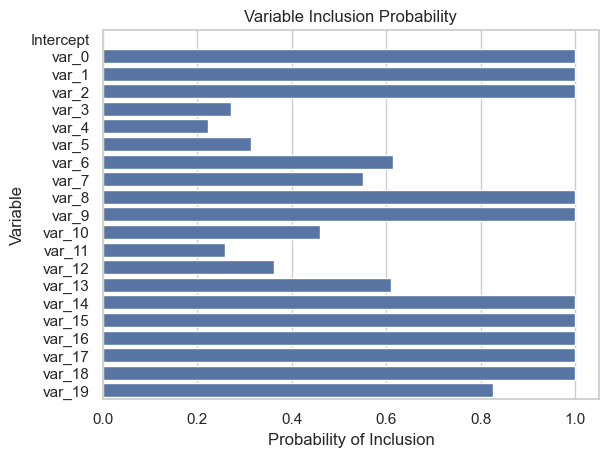

In [16]:
g = sns.barplot(x = "probability", 
                y = "variable", 
                data = my_vip_df)
g.set(title = "Variable Inclusion Probability",
      xlabel = "Probability of Inclusion",
      ylabel = "Variable")
plt.show()

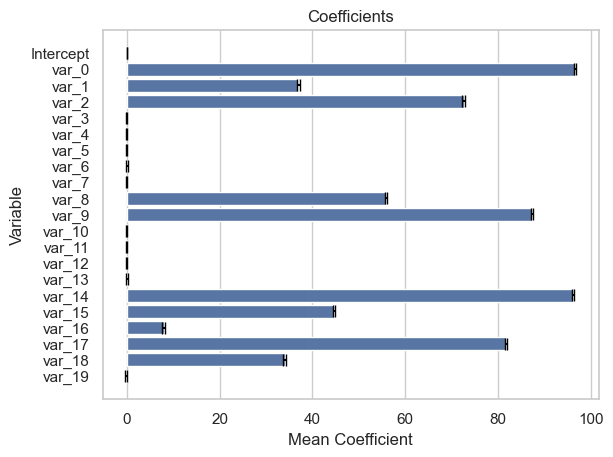

In [17]:
g = sns.barplot(x = "mean_coef", 
                y = "variable", 
                data = my_coef_df)
g.errorbar(x = my_coef_df["mean_coef"], 
           y = my_coef_df["variable"], 
           xerr = my_coef_df["p_95"] - my_coef_df["p_05"], 
           fmt = "none",
           color = "black",
           capsize = 4)
g.set(title = "Coefficients",
      xlabel = "Mean Coefficient",
      ylabel = "Variable")
plt.show()

### Experiment 4
+ Add parallelization to function from experiment 3

In [18]:
# joblib is more userfriendly than multiprocessing
from joblib import Parallel, delayed

In [19]:
def bolasso_parallel(formula, data, n_boot):
    # Create matrices
    df_y, df_X = patsy.dmatrices(formula, data = data)
    # Simple bootstrap
    n_rows = df_X.shape[0]
    n_cols = df_X.shape[1]
    # Empty matrix to store coefficients; each row will be a bootstrap outcome, each column a variable
    bs_results = np.empty(shape = (n_boot, n_cols))
    # Define inner function for passing to parallel
    # Convert to numpy array to fix issue with parallelization pickling
    X = np.asarray(df_X)
    y = np.asarray(df_y).ravel()
    def inner_func(i):
         # Randomly sample row indices with replacement
        idx = np.random.randint(0, n_rows-1, n_rows)
        # Fit Lasso regression on sampled rows with CV Lambda
        reg = LassoCV(cv = 5, random_state = 0).fit(X[idx,], y[idx,])
        # Store coefficients
        return reg.coef_
    bs_results = Parallel(n_jobs = -2)(delayed(inner_func)(i) for i in range(n_boot))
    bs_results = np.array(bs_results)
    # Parse inclusion probabilities output into dataframe
    vip_df = pd.DataFrame({"variable": df_X.design_info.column_names, 
                       "probability": (abs(bs_results) > 0).mean(axis = 0)})
    # Parse coefficients output into dataframe
    coef_df = pd.DataFrame({"variable": df_X.design_info.column_names, 
                       "mean_coef": bs_results.mean(axis = 0),
                       "p_05": np.percentile(bs_results, q = 5, axis = 0),
                       "p_95": np.percentile(bs_results, q = 95, axis = 0)})
    return vip_df, coef_df
    

#### Compare speeds and Outputs

In [20]:
%%timeit
my_vip_df_1, my_coef_df_1 = bolasso_parallel(formula = my_formula,
                                             data = df,
                                             n_boot = 500)

1.62 s ± 85.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%%timeit
my_vip_df_2, my_coef_df_2 = bolasso(formula = my_formula,
                                    data = df,
                                    n_boot = 500)

16.2 s ± 819 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
my_vip_df_1, my_coef_df_1 = bolasso_parallel(formula = my_formula,
                                             data = df,
                                             n_boot = 500)
my_vip_df_2, my_coef_df_2 = bolasso(formula = my_formula,
                                    data = df,
                                    n_boot = 500)

In [23]:
my_vip_df_1["run"] = "parallel"
my_vip_df_2["run"] = "single-threaded"
my_coef_df_1["run"] = "parallel"
my_coef_df_2["run"] = "single-threaded"

my_vip_df = pd.concat([my_vip_df_1, my_vip_df_2])
my_coef_df = pd.concat([my_coef_df_1, my_coef_df_2])

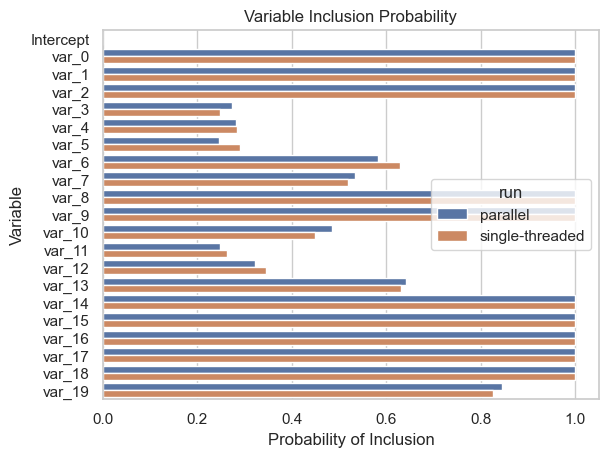

In [24]:
g = sns.barplot(x = "probability", 
                y = "variable", 
                hue = "run",
                data = my_vip_df)
g.set(title = "Variable Inclusion Probability",
      xlabel = "Probability of Inclusion",
      ylabel = "Variable")
plt.show()

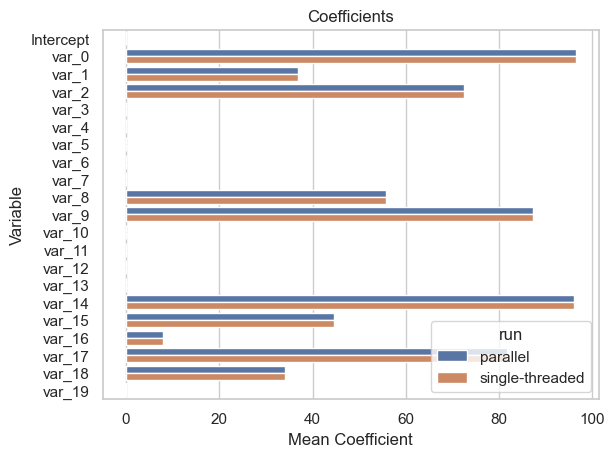

In [25]:
g = sns.barplot(x = "mean_coef", 
                y = "variable", 
                hue = "run",
                data = my_coef_df)
g.set(title = "Coefficients",
      xlabel = "Mean Coefficient",
      ylabel = "Variable")
plt.show()